# State Schema

## Review

Goals

Building a deeper understanding of both state and memory.

## Schema

When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

The state schema represents the structure and types of data that our graph will use.

All nodes are expected to communicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!


In [8]:
from typing_extensions import TypedDict
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal['happy', 'sad']

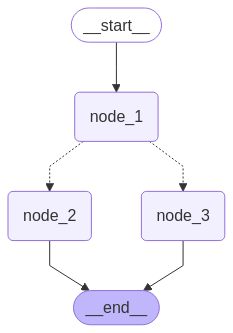

In [9]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:

    if random.random() < 0.5:
        return "node_2"
    
    return "node_3"

#Builder graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
graph.invoke({'name': "Raahul"})

---Node 1---
---Node 3---


{'name': 'Raahul is ... ', 'mood': 'sad'}

## Dataclass

Python's [dataclasses](https://docs.python.org/3/library/dataclasses.html) provide [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes).

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

In [11]:
from dataclasses import dataclass

@dataclass
class DataClassState:
    name: str
    mood: Literal["happy", "sad"]

To access the keys of a `dataclass`, we just need to modify the subscripting used in `node_1`: 

* We use `state.name` for the `dataclass` state rather than `state["name"]` for the `TypedDict` above

You'll notice something a bit odd: in each node, we still return a dictionary to perform the state updates.
 
This is possible because LangGraph stores each key of your state object separately.

The object returned by the node only needs to have keys (attributes) that match those in the state!

In this case, the `dataclass` has key `name` so we can update it by passing a dict from our node, just as we did when state was a `TypedDict`.

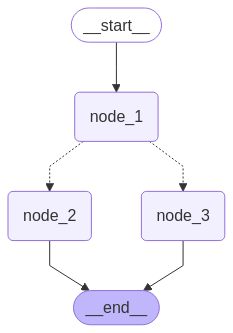

In [12]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ..."}

# Build graph
builder = StateGraph(DataClassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [13]:
graph.invoke(DataClassState(name="Raahul", mood="mad"))

---Node 1---
---Node 3---


{'name': 'Raahul is ...', 'mood': 'sad'}

## Pydantic

As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime. 
 
This means you could potentially assign invalid values without raising an error!

For example, we can set `mood` to `mad` even though our type hint specifies `mood: list[Literal["happy","sad"]]`.

In [14]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str

    @field_validator('mood')
    @classmethod

    def validate_mood(cls, value):
        if value not in ['happy', 'sad']:
            raise ValidationError("Each mood must be 'happy' or 'sad'")
        return value
    
try:
    state = PydanticState(name="Raahul", mood='sad')
except ValidationError as e:
    print("ValidationError:", e)

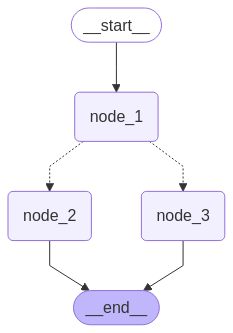

In [15]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Change the mood to anything other than happy or sad.

In [16]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ...', 'mood': 'sad'}

# State Reducers

Goals
- Dive into reducers, which specify how State updates are performed on specififc keys / channels in the state schema

## Default - Overwriting State

Branching

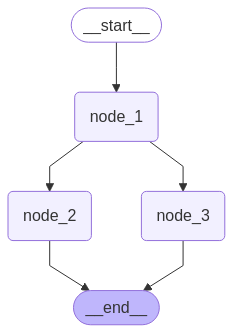

In [17]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo']+1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo']+1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo']+1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [18]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"foo":1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occured: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occured: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

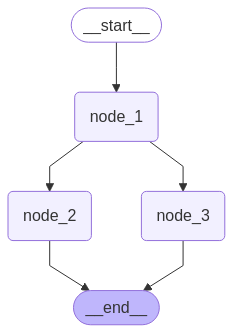

In [19]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo : Annotated[list[int], add]

def node_1(state):
    print("---Node 1")
    return {'foo': [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2")
    return {'foo': [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3")
    return {'foo': [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [20]:
graph.invoke({'foo':[1]})

---Node 1
---Node 2
---Node 3


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`. 

In [21]:
try:
    graph.invoke({"foo": None})
except TypeError as e:
    print(f"TypedError occurred: {e}")

TypedError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

In [22]:
def reduce_list(left:list|None, right: list|None)-> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """

    if not left:
        left = []
    if not right:
        right = []
    
    return left+right

class DefaultState(TypedDict):
    foo : Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo : Annotated[list[int], reduce_list]

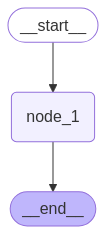

TypeError occurred: can only concatenate list (not "NoneType") to list


In [23]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Lets, try using our custom reducer. We can see that no error is thrown.

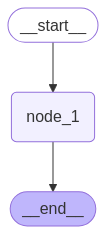

---Node 1---
{'foo': [2]}


In [24]:
# Builder graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

try:
    print(graph.invoke({"foo":None}))
except TypeError as e:
    print(f"TypeError occured: {e}")

## Messages

Re-writng

If we pass a message with the sameID as an exisiting one in our `messages` list, `add_messages` reducer will overwrite it

In [25]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on CHennai Super Kings.", name="Raahul", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on MS Dhoni, specifically", name="Raahul", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on MS Dhoni, specifically", additional_kwargs={}, response_metadata={}, name='Raahul', id='2')]

Removal

`add_messages` also enables message removal.

In [26]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Raahul", id="2"))
messages.append(AIMessage("So you said you were intrested on IPL", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I just started following IPL, tell me more about this league", name="Raahul", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[0:2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [27]:
add_messages(messages, delete_messages)

[AIMessage(content='So you said you were intrested on IPL', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I just started following IPL, tell me more about this league', additional_kwargs={}, response_metadata={}, name='Raahul', id='4')]

# Multiple Schemas

Goals

* Internal nodes may pass information that is *not required* in the graph's input / output.

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

## Private State

[Private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

We'll define an `OverallState` and a `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

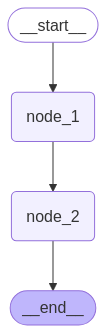

In [28]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    bar: int

def node_1(state:OverallState)-> PrivateState:
    print("---Node 1---")
    return {"bar": state['foo'] + 1}

def node_2(state:PrivateState)-> OverallState:
    print("---Node 2---")
    return {"foo": state['bar'] + 1}

# Builder graph 
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [29]:
graph.invoke({"foo": 1})

---Node 1---
---Node 2---


{'foo': 3}

## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. 

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.

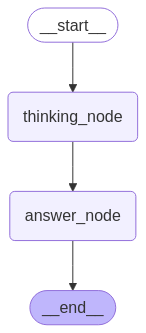

In [30]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes":"...his name is Raahul"}

def answer_node(state: OverallState):
    return {"answer": "bye Raahul"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Notice, that the output of invoke contains all keys in `OverallState`

In [31]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Raahul', 'notes': '...his name is Raahul'}

Now, let's use a specific `input` and `output` schema with our graph.

Here, `input` / `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph. 

In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes.

This is important when the graph is using multiple schemas.

We use type hints below to, for example, show that the output of `answer_node` will be filtered to `OutputState`. 

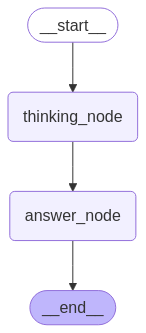

{'answer': 'Bye Raahul'}

In [32]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question:str
    answer:str
    notes: str

def thinking_node(state: InputState):
    return{"answer": "Bye", "notes":".. his name is Raahul"}

def answer_node(state: OverallState)-> OutputState:
    return {"answer": "Bye Raahul"}

# Builder
graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

# Compile
graph = graph.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Invoke
graph.invoke({"question": "hi"})

# Filtering and trimming messages

Goals
 
- To build a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

## Messages as state

In [33]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were looking into CSK?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know little about the team, Wanna know more", name="Raahul"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were looking into CSK?
================================ Human Message =================================
Name: Raahul

Yes, I know little about the team, Wanna know more


In [34]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-nano")
llm.invoke(messages)

AIMessage(content='Sure! Chennai Super Kings (CSK) is a popular franchise in the Indian Premier League (IPL). Here\'s some information to get you started:\n\n**Overview:**\n- **Founded:** 2008\n- **Location:** Chennai, Tamil Nadu, India\n- **Stadium:** M.A. Chidambaram Stadium\n- **Team Colors:** Yellow and Navy Blue\n\n**Achievements:**\n- **IPL Titles:** 4 (2010, 2011, 2018, 2021)\n- **Consistent Performers:** Known for their consistency and strong team strategy\n- **Captain:** Mahendra Singh Dhoni (as of 2023)\n\n**Key Players (as of 2023):**\n- Mahendra Singh Dhoni (Captain)\n- Ravindra Jadeja\n- Ruturaj Gaikwad\n- Deepak Chahar\n- Moeen Ali\n\n**Notable Traits:**\n- Known for excellent team coordination and strategic gameplay.\n- Has a loyal fan base called the "Yellow Army."\n- Managed by CSK Cricket Limited, owned by India Cements.\n\nWould you like to know about recent seasons, famous players, or some interesting facts about CSK?', additional_kwargs={'refusal': None}, response_

We can run our chat model in a simple graph with `MessagesState`.

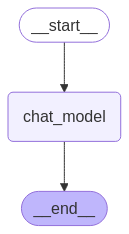

In [35]:
from IPython.display import Image,display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return{"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
output = graph.invoke({'messages': messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were looking into CSK?
================================ Human Message =================================
Name: Raahul

Yes, I know little about the team, Wanna know more
================================== Ai Message ==================================

Certainly! Chennai Super Kings (CSK) is one of the most popular and successful franchises in the Indian Premier League (IPL). Here’s some information to get you started:

**Overview:**
- **Full Name:** Chennai Super Kings
- **Founded:** 2008
- As of 2023, CSK is one of the oldest teams in the IPL.
- **Home Ground:** M. A. Chidambaram Stadium in Chennai, Tamil Nadu
- **Team Colors:** Yellow and Blue

**Team Highlights:**
- **Championships:** CSK has won the IPL title multiple times, making them one of the most successful teams in the league.
- **Captain:** Mahendra Singh Dhoni has been the iconic captain for many years, leading the te

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

`RemoveMessage` and the `add_messages` reducer.

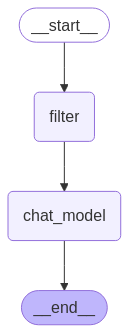

In [37]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build Graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Raahul", id="2"))
messages.append(AIMessage(f"So you said you were looking into CSK?", name="Bot", id="3"))
messages.append(HumanMessage(f"Yes, I know little about the team, Wanna know more Dhoni", name="Raahul", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were looking into CSK?
================================ Human Message =================================
Name: Raahul

Yes, I know little about the team, Wanna know more Dhoni
================================== Ai Message ==================================

Certainly! M.S. Dhoni, whose full name is Mahendra Singh Dhoni, is a legendary Indian cricketer renowned for his exceptional leadership and finishing skills. Here's some information about him:

**Basic Details:**
- Full Name: Mahendra Singh Dhoni
- Born: July 7, 1981, Ranchi, Jharkhand, India
- Role: Wicket-keeper, Batsman
- Batting Style: Right-handed
- Captaincy: Captain of Chennai Super Kings (CSK) in the Indian Premier League (IPL), and formerly the Indian national team

**Career Highlights:**
- Known for his calm demeanor and sharp cricketing mind
- Led India to numerous successes, including the 2007 ICC T20 World Cup, 201

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

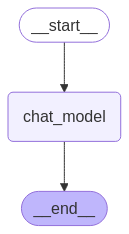

In [39]:
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Builder graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [40]:
messages.append(output["messages"][-1])
messages.append(HumanMessage(f"Tell me more about Suresh Raina", name="Raahul"))

In [41]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Raahul

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were looking into CSK?
================================ Human Message =================================
Name: Raahul

Yes, I know little about the team, Wanna know more Dhoni
================================== Ai Message ==================================

Certainly! M.S. Dhoni, whose full name is Mahendra Singh Dhoni, is a legendary Indian cricketer renowned for his exceptional leadership and finishing skills. Here's some information about him:

**Basic Details:**
- Full Name: Mahendra Singh Dhoni
- Born: July 7, 1981, Ranchi, Jharkhand, India
- Role: Wicket-keeper, Batsman
- Batting Style: Right-handed
- Captaincy: Captain of Chennai Super Kings (CSK) in the Indian Premier League (IPL),

In [42]:
# Invoke
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Raahul

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were looking into CSK?
================================ Human Message =================================
Name: Raahul

Yes, I know little about the team, Wanna know more Dhoni
================================== Ai Message ==================================

Certainly! M.S. Dhoni, whose full name is Mahendra Singh Dhoni, is a legendary Indian cricketer renowned for his exceptional leadership and finishing skills. Here's some information about him:

**Basic Details:**
- Full Name: Mahendra Singh Dhoni
- Born: July 7, 1981, Ranchi, Jharkhand, India
- Role: Wicket-keeper, Batsman
- Batting Style: Right-handed
- Captaincy: Captain of Chennai Super Kings (CSK) in the Indian Premier League (IPL),

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

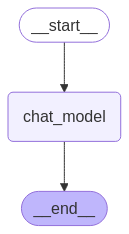

In [43]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state['messages'],
        max_tokens=100,
        strategy='last',
        token_counter=ChatOpenAI(model="gpt-4"),
        allow_partial=False
    )

    return {'messages': [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me about csk head coaches", name="Raahul"))

In [45]:
trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    token_counter=ChatOpenAI(model="gpt-4"),
    allow_partial=False
)

[HumanMessage(content='Tell me about csk head coaches', additional_kwargs={}, response_metadata={}, name='Raahul')]

In [46]:
messages_out_trim = graph.invoke({'messages': messages})

In [47]:
for m in messages_out_trim['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Raahul

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were looking into CSK?
================================ Human Message =================================
Name: Raahul

Yes, I know little about the team, Wanna know more Dhoni
================================== Ai Message ==================================

Certainly! M.S. Dhoni, whose full name is Mahendra Singh Dhoni, is a legendary Indian cricketer renowned for his exceptional leadership and finishing skills. Here's some information about him:

**Basic Details:**
- Full Name: Mahendra Singh Dhoni
- Born: July 7, 1981, Ranchi, Jharkhand, India
- Role: Wicket-keeper, Batsman
- Batting Style: Right-handed
- Captaincy: Captain of Chennai Super Kings (CSK) in the Indian Premier League (IPL),

# Chatbot with message summarization

Goals

- Using the llm to produce a running summary of the conversation
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filering 

- And, will equip the Chatbot with memory, supporting long-running conversations without incurring high token cost / latency 

In [48]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

In [49]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

class State(MessagesState):
    summary : str

def call_node(state: State):

    summary = state.get("summary", "")

    if summary:

        system_message = f"Summary of conversation earlier: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [50]:
def summarize_conversation(state: State):

    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Creating a summary of the conversation above:"

    # Adding prompt to history 
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

Adding a conditional edge to determine whether to produce a summary based on the conversation length.

In [51]:
from langgraph.graph import END
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    return END

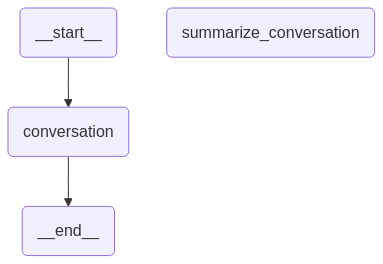

In [52]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)
workflow.add_node("conversation", call_node)
workflow.add_node(summarize_conversation)
# workflow.add_node(should_continue)
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [53]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Conversation
input_messages = HumanMessage(content="Hi!, I'm Raahul")
output = graph.invoke({"messages": [input_messages]}, config)

for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the CSK!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello, Raahul! Nice to meet you. How can I assist you today?
================================== Ai Message ==================================

Your name is Raahul.
================================== Ai Message ==================================

That's great! Chennai Super Kings (CSK) is a popular and successful cricket team. Do you have a favorite player or a memorable moment from their matches?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [54]:
graph.get_state(config).values.get("summary","")

''

In [55]:
input_message = HumanMessage(content="My favorite player is MS Dhoni aka Thala")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Excellent choice! MS Dhoni, aka Thala, is truly legendary—known for his calm demeanor, incredible finishing skills, and leadership. Do you have a favorite Dhoni moment or match?


In [56]:
input_message = HumanMessage(content="All the lighting fast stumping to last ball sizers")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Absolutely! Dhoni is renowned for his lightning-fast stumpings and cool-headed finishes, especially in high-pressure situations like the last ball of a match. His quick reflexes and sharp wicket-keeping skills have made some of the most memorable moments in cricket history. Do you have a favorite stumping or match where Dhoni's quickness stood out?


In [57]:
graph.get_state(config).values.get("summary","")

"Sure! Here's a summary of our conversation:\n\nYou introduced yourself as Raahul and mentioned that you like CSK. You shared that your favorite player is MS Dhoni, also known as Thala. I responded by acknowledging his legendary status and asked if you have a favorite Dhoni moment or match."

# Chatbot with message summarizaton & external DB memory

Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

## Sqlite

Resource for  [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [58]:
import sqlite3

conn = sqlite3.connect(":memory:", check_same_thread = False)

In [59]:
# !mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [60]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [61]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage

from langgraph.graph import START, MessagesState, END, StateGraph

model = ChatOpenAI(model='gpt-4.1-nano', temperature=0)

class State(MessagesState):
    summary: str

def call_model(state: State):

    summary = state.get("summary", "")

    if summary:

        system_message = f"Summary of conversation earlier: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):

    summary = state.get("summary", "")

    if summary:

        summary_message = (
            f"This is summary of the conversation to date: {summary}\n \n"
            "Extend the summary by talking into account the new messages above: "
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state:State):

    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_conversation"
    
    return END

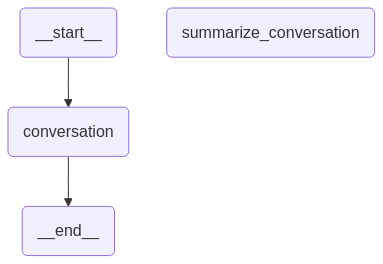

In [62]:
from IPython.display import Image, display

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [63]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Raahul")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the Chennai Super Kings!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello again, Raahul! How can I assist you today?
================================== Ai Message ==================================

Your name is Raahul. How can I help you today?
================================== Ai Message ==================================

That's great! Chennai Super Kings are a popular and successful cricket team. Do you have a favorite player or a memorable match you'd like to talk about?


In [64]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Raahul", additional_kwargs={}, response_metadata={}, id='4c5f795d-623e-4e51-8618-9b482192a4b4'), AIMessage(content='Hello again, Raahul! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 269, 'total_tokens': 284, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_eede8f0d45', 'id': 'chatcmpl-BUb4aDdayx4ODBW7NEbafuAS5gWVM', 'finish_reason': 'stop', 'logprobs': None}, id='run-f14f754a-2161-4404-86b6-a85e0062bd1d-0', usage_metadata={'input_tokens': 269, 'output_tokens': 15, 'total_tokens': 284, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage

## Persisting State

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.

In [65]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Raahul", additional_kwargs={}, response_metadata={}, id='4c5f795d-623e-4e51-8618-9b482192a4b4'), AIMessage(content='Hello again, Raahul! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 269, 'total_tokens': 284, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_eede8f0d45', 'id': 'chatcmpl-BUb4aDdayx4ODBW7NEbafuAS5gWVM', 'finish_reason': 'stop', 'logprobs': None}, id='run-f14f754a-2161-4404-86b6-a85e0062bd1d-0', usage_metadata={'input_tokens': 269, 'output_tokens': 15, 'total_tokens': 284, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage